In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [ ]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState

class Todo(TypedDict):
  """
  A structured task item for tracking progress through complex workflows.

  Attributes:
      content: Short, specific description of the task
      status: Current state - pending, in_progress, or completed
  """
  
  content: str
  status: Literal['pending', 'in_progress', 'completed']
  

class DeepAgentState(AgentState):
    """
    Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    """
    
    # Incoming todos will replace the current todos
    todos: NotRequired[list[Todo]]

In [ ]:
from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

WRITE_TODOS_DESCRIPTION = """
Create and manage structured task lists for tracking progress through complex workflows.

## When to Use
- Multi-step or non-trivial tasks requiring coordination
- When user provides multiple tasks or explicitly requests todo list  
- Avoid for single, trivial actions unless directed otherwise

## Structure
- Maintain one list containing multiple todo objects (content, status, id)
- Use clear, actionable content descriptions
- Status must be: pending, in_progress, or completed

## Best Practices  
- Only one in_progress task at a time
- Mark completed immediately when task is fully done
- Always send the full updated list when making changes
- Prune irrelevant items to keep list focused

## Progress Updates
- Call TodoWrite again to change task status or edit content
- Reflect real-time progress; don't batch completions  
- If blocked, keep in_progress and add new task describing blocker

## Parameters
- todos: List of TODO items with content and status fields

## Returns
Updates agent state with new todo list.
"""

@tool(description=WRITE_TODOS_DESCRIPTION, parse_docstring=True)
def write_todos(
  todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    print("at write_todos")
    print(f"write_todos.todos {todos}")

    return Command(
      update={
        "todos": todos,
        "messages": [
          ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
        ]
      }
    )

@tool(parse_docstring=True)
def read_todos(
  state: Annotated[DeepAgentState, InjectedState],
) -> str:
    """
    Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list

    Returns:
        Formatted string representation of the current TODO list
    """
    print("at read_todos")
    
    todos = state.get("todos", [])
    if not todos:
      return "No todos currently in the list"
    
    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
      result += f"{i}. {todo['content'] ({todo['status']})}\n"
    
    return result.strip()

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """

    print("at web_search")
    print(f"web_search.query {query}")

    return search_result

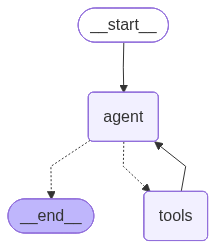

In [4]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

model = init_chat_model(model='openai:gpt-4.1-mini')
tools = [write_todos, read_todos, web_search]

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """
IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question.
"""
TODO_USAGE_INSTRUCTIONS="""
Based upon the user's request:
1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.
2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan. 
3. Reflect on what you've done and the TODO.
4. Mark you task as completed, and proceed to the next TODO.
5. Continue this process until you have completed all TODOs.

IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY user request.
IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have to keep track of.
"""

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me a short summary of the Model Context Protocol (MCP).",
            }
        ],
        "todos": [],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me a short summary of the Model Context Protocol (MCP).                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research and gather information about the Model Context Protocol (MCP).",                     │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_HPMf5y0av0FpltZC7dZa5kBv                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research and gather information about the Model Context Protocol (MCP).',    │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research and gather information about the Model Context Protocol (MCP).",                     │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_Sryd3gnZtBBUAYpFBVlIlWgK                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research and gather information about the Model Context Protocol (MCP).',    │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: call_C4vtR2R5bJIjf7f8tUY549ue                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research and gather information about the Model Context Protocol (MCP).",                     │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_mQiNtISurXJ5gDOJQDylJz69                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research and gather information about the Model Context Protocol (MCP).',    │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic. It facilitates seamless   │
│ integration between AI models and external systems such as tools, databases, and other services. MCP serves as  │
│ a standardized communication layer, enabling AI models to access and use data from diverse sources consistently │
│ and efficiently. In essence, it simplifies connecting AI assistants to external services by providing a unified │
│ language for data exchange.                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯